In [266]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import warnings

# plt.style.use('seaborn-darkgrid')
# warnings.filterwarnings("ignore")


In [267]:
train_data = pd.read_csv('/home/chinmay/Documents/Internship/TASK1/train.csv')
test_data = pd.read_csv('/home/chinmay/Documents/Internship/TASK1/test.csv')

train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [268]:
null_value = pd.DataFrame()
null_value['variable'] = test_data.columns
null_value['Train'] = train_data.drop(labels='SalePrice', axis=1).isnull().sum().to_list()
null_value['Test'] = test_data.isnull().sum().to_list()
null_value

,variable,Train,Test
0,Id,0,0
1,MSSubClass,0,0
2,MSZoning,0,4
3,LotFrontage,259,227
4,LotArea,0,0
...,...,...,...
75,MiscVal,0,0
76,MoSold,0,0
77,YrSold,0,0
78,SaleType,0,1


In [269]:
no_null_col = null_value[(null_value['Train']==0) & (null_value['Test']==0)].variable.to_list()

In [270]:
df_train = train_data[no_null_col]
df_train['SalePrice'] = train_data['SalePrice']
df_test = test_data[no_null_col]
df_test.describe().T

/tmp/ipykernel_4411/2801459933.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['SalePrice'] = train_data['SalePrice']


,count,mean,std,min,25%,50%,75%,max
Id,1459.0,2190.000000,421.321334,1461.0,1825.5,2190.0,2554.5,2919.0
MSSubClass,1459.0,57.378341,42.746880,20.0,20.0,50.0,70.0,190.0
LotArea,1459.0,9819.161069,4955.517327,1470.0,7391.0,9399.0,11517.5,56600.0
OverallQual,1459.0,6.078821,1.436812,1.0,5.0,6.0,7.0,10.0
OverallCond,1459.0,5.553804,1.113740,1.0,5.0,5.0,6.0,9.0
YearBuilt,1459.0,1971.357779,30.390071,1879.0,1953.0,1973.0,2001.0,2010.0
YearRemodAdd,1459.0,1983.662783,21.130467,1950.0,1963.0,1992.0,2004.0,2010.0
1stFlrSF,1459.0,1156.534613,398.165820,407.0,873.5,1079.0,1382.5,5095.0
2ndFlrSF,1459.0,325.967786,420.610226,0.0,0.0,0.0,676.0,1862.0
LowQualFinSF,1459.0,3.543523,44.043251,0.0,0.0,0.0,0.0,1064.0


/tmp/ipykernel_4411/3602787827.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  axis[1] = sns.distplot(data)


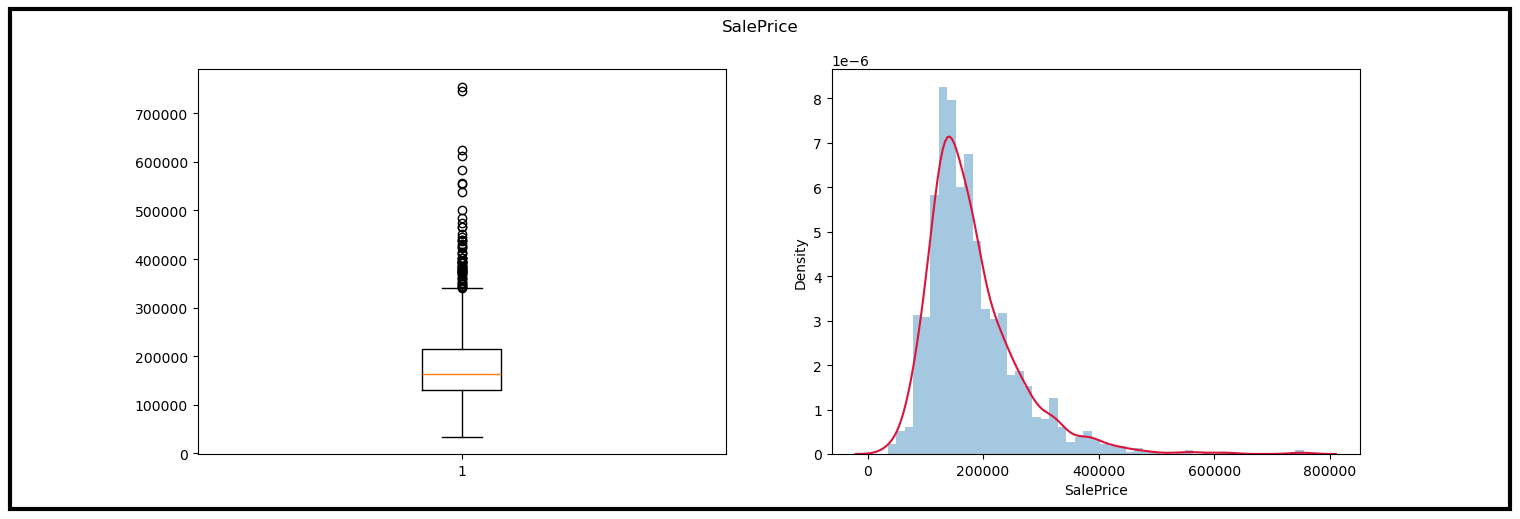

In [271]:
def plot_hist_box(data):
    fig, axis = plt.subplots(1,2,figsize=(15,5))
    plt.suptitle(data.name)
    axis[0].boxplot(data)
    axis[1] = sns.distplot(data)
    axis[1].lines[0].set_color('crimson')
    rect = plt.Rectangle(
        (0,0),1,1,fill=False, color="k", lw=3, transform=fig.transFigure, figure=fig
    )
    fig.patches.extend([rect])
    plt.show()

plot_hist_box(df_train.SalePrice)

In [272]:
df_train['House_Age'] = df_train.YrSold - df_train.YearBuilt
df_train['RemodAge']  = df_train.YrSold - df_train.YearRemodAdd
df_train.drop(labels=['YrSold','YearBuilt','YearRemodAdd'],inplace=True,axis=1)

/tmp/ipykernel_4411/3482038859.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['House_Age'] = df_train.YrSold - df_train.YearBuilt
/tmp/ipykernel_4411/3482038859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['RemodAge']  = df_train.YrSold - df_train.YearRemodAdd
/tmp/ipykernel_4411/3482038859.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

/tmp/ipykernel_4411/3602787827.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  axis[1] = sns.distplot(data)


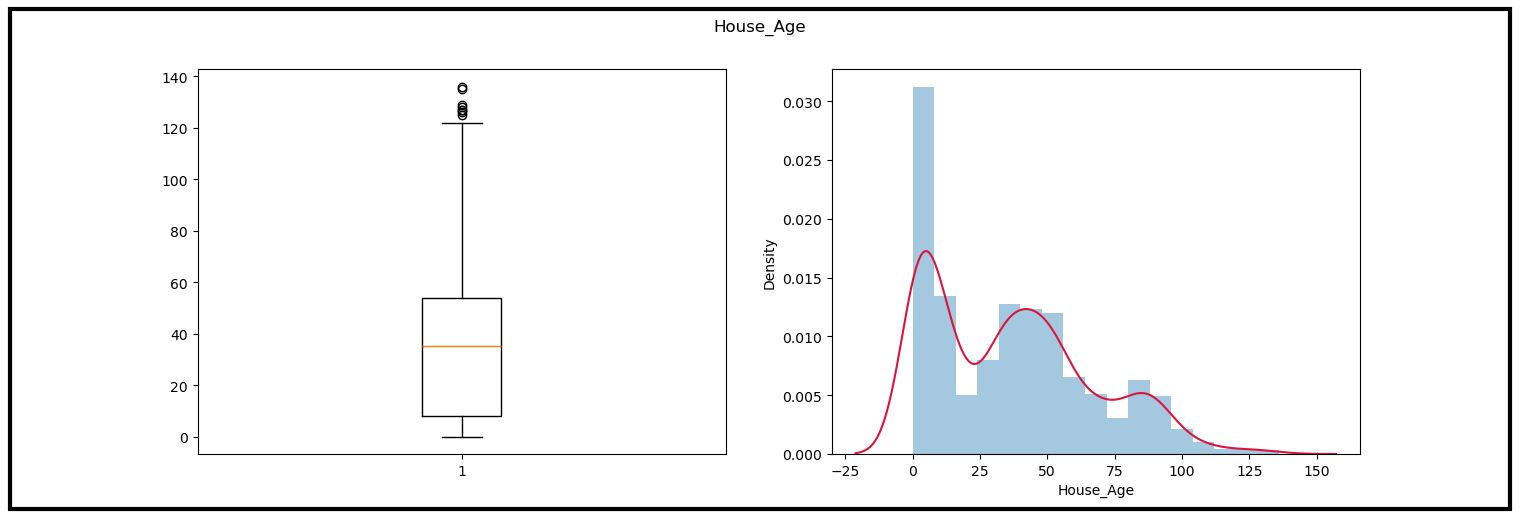

In [273]:
plot_hist_box(df_train.House_Age)

/tmp/ipykernel_4411/3602787827.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  axis[1] = sns.distplot(data)


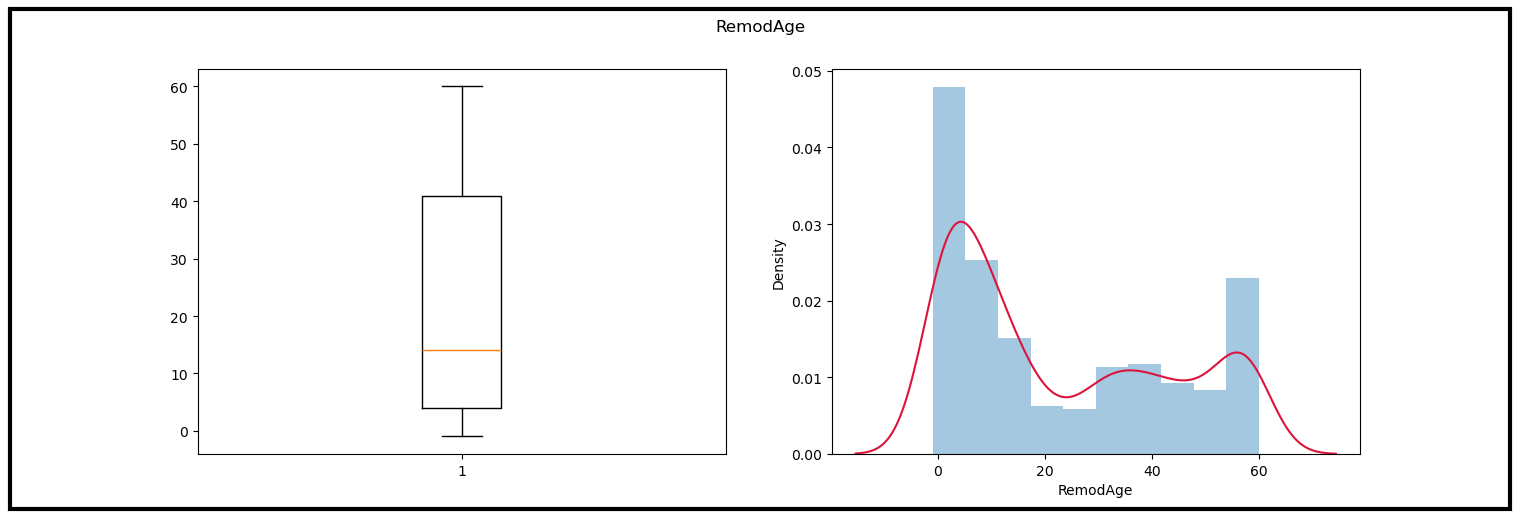

In [274]:
plot_hist_box(df_train.RemodAge)

In [275]:
df_test['House_Age'] = df_test.YrSold - df_test.YearBuilt
df_test['RemodAge'] = df_test.YrSold - df_test.YearRemodAdd
df_test.drop(labels=['YrSold', 'YearBuilt', 'YearRemodAdd'], inplace=True, axis=1)

/tmp/ipykernel_4411/210790364.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['House_Age'] = df_test.YrSold - df_test.YearBuilt
/tmp/ipykernel_4411/210790364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['RemodAge'] = df_test.YrSold - df_test.YearRemodAdd
/tmp/ipykernel_4411/210790364.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [276]:
df_train['Overall_Rating'] = (df_train.OverallCond + df_train.OverallQual) * 0.5
df_test['Overall_Rating'] = (df_test.OverallCond + df_test.OverallQual) * 0.5
df_train.drop(labels=['OverallQual', 'OverallCond'], inplace=True, axis=1)
df_test.drop(labels=['OverallQual', 'OverallCond'], inplace=True, axis=1)

/tmp/ipykernel_4411/1740926703.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Overall_Rating'] = (df_train.OverallCond + df_train.OverallQual) * 0.5
/tmp/ipykernel_4411/1740926703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Overall_Rating'] = (df_test.OverallCond + df_test.OverallQual) * 0.5
/tmp/ipykernel_4411/1740926703.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

/tmp/ipykernel_4411/3602787827.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  axis[1] = sns.distplot(data)


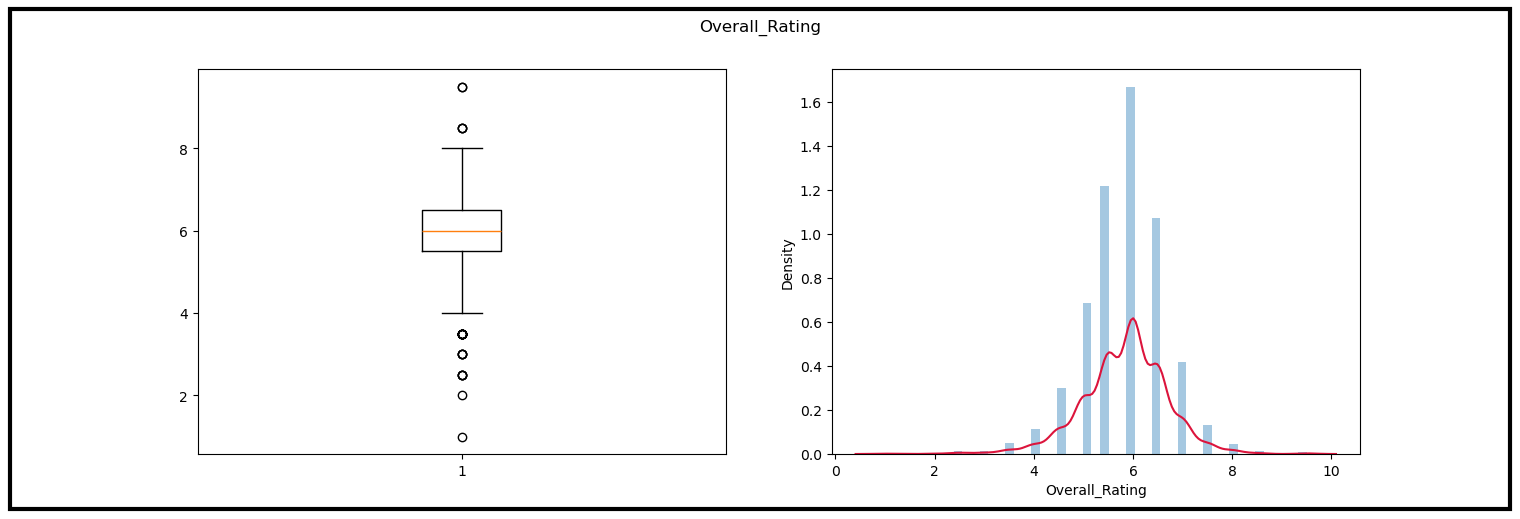

In [277]:
plot_hist_box(df_train.Overall_Rating)

In [278]:
train_data.Street.isnull().sum()
df_train['LotFrontage'] = train_data.LotFrontage
df_test['LotFrontage'] = train_data.LotFrontage

imputer =  KNNImputer(n_neighbors=2)
df_train.LotFrontage = imputer.fit_transform(df_train[['LotFrontage']])
df_test.LotFrontage = imputer.fit_transform(df_test[['LotFrontage']])

/tmp/ipykernel_4411/1791129722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['LotFrontage'] = train_data.LotFrontage
/tmp/ipykernel_4411/1791129722.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['LotFrontage'] = train_data.LotFrontage
/tmp/ipykernel_4411/1791129722.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

/tmp/ipykernel_4411/3602787827.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  axis[1] = sns.distplot(data)


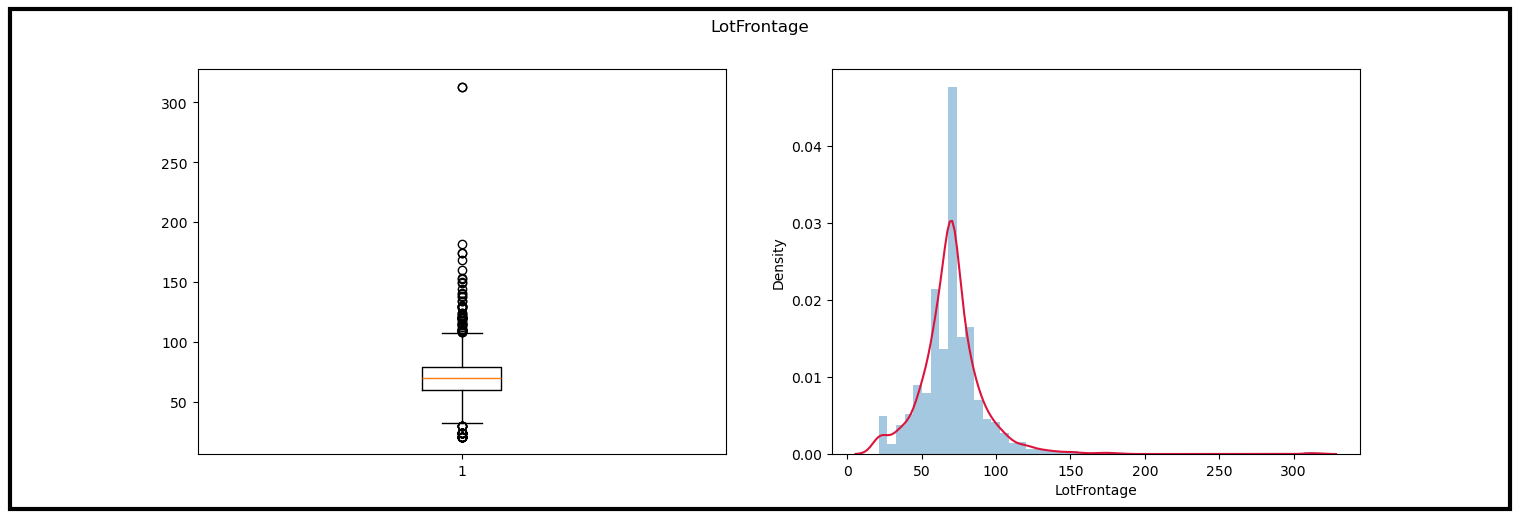

In [279]:
plot_hist_box(df_train.LotFrontage)

/tmp/ipykernel_4411/3602787827.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  axis[1] = sns.distplot(data)


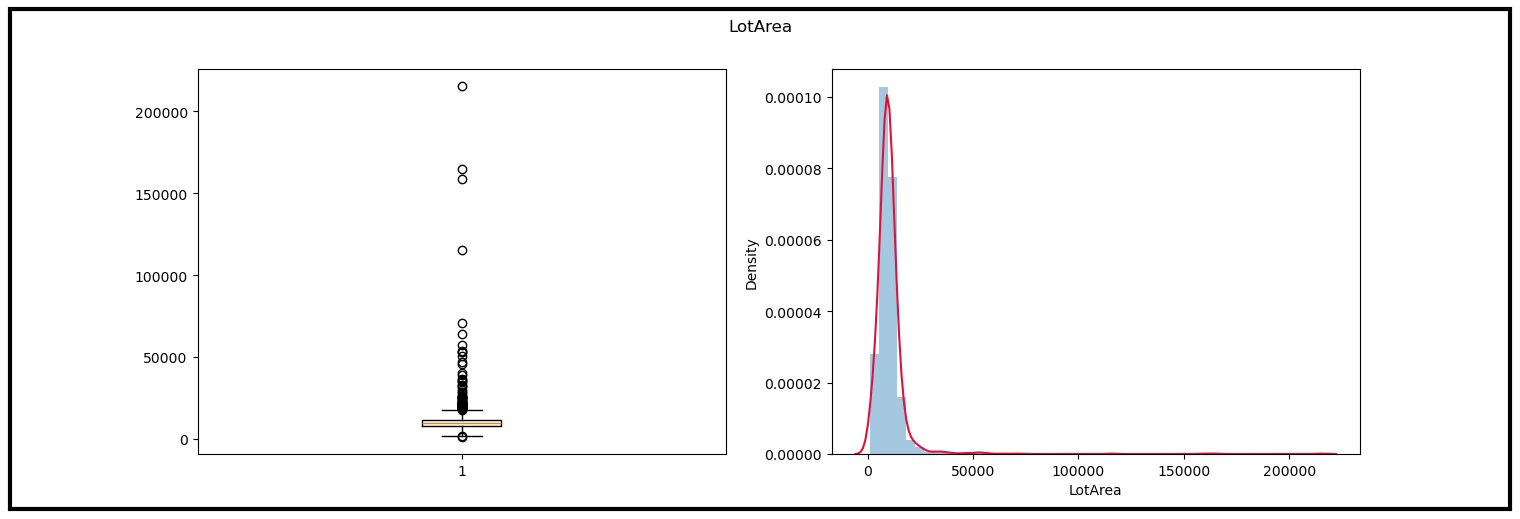

In [280]:
plot_hist_box(df_train.LotArea)

In [281]:
train_MS_label = set(df_train.MSSubClass.value_counts().index.tolist())
test_MS_label = set(df_test.MSSubClass.value_counts().index.tolist())
print(f"Additional data in test is {test_MS_label - train_MS_label}")

df_train = pd.get_dummies(df_train, columns=['MSSubClass'])
df_test = pd.get_dummies(df_test, columns=['MSSubClass'])

df_t_0_1 = [0]*df_train.shape[0]
df_0 = pd.DataFrame(df_t_0_1, columns=['MSSubClass_150'])
df_train = df_train.join(df_0)

Additional data in test is {150}


In [282]:
df_train.columns[df_train.dtypes != 0]

Index(['Id', 'LotArea', 'Street', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond',
       'Foundation', 'Heating', 'HeatingQC', 'CentralAir', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'SaleCondition',
       'SalePrice', 'House_Age', 'RemodAge', 'Overall_Rating', 'LotFrontage',
       'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45',
       'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75',
       'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120',
       'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_150'],
      dtype='object')

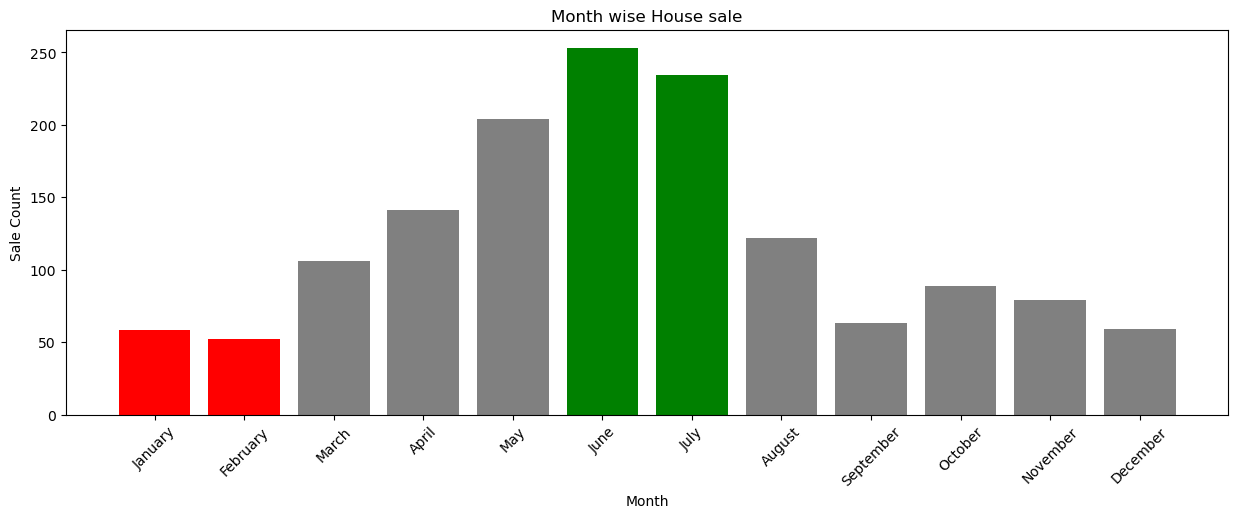

In [283]:
from calendar import month_name
from collections import OrderedDict

x = lambda x : datetime.date(1900, x, 1).strftime('%B')
month = list(map(x, df_train.MoSold.value_counts().index.to_list()))
sale_count = df_train.MoSold.value_counts().to_list()
month_sale = dict(zip(month, sale_count))
monthj = list(month_name)
monthj.remove('')
month_sale = OrderedDict([(a, month_sale[a]) for a in monthj])
plt.figure(figsize=(15,5))
colors = ['r', 'r', 'gray', 'gray', 'gray', 'g', 'g', 'gray', 'gray', 'gray', 'gray', 'gray']
plt.bar(month_sale.keys(), month_sale.values(), color=colors)
plt.title('Month wise House sale')
plt.xlabel('Month')
plt.ylabel('Sale Count')
plt.xticks(rotation=45)
plt.show()

In [284]:
df_train = pd.get_dummies(df_train, columns=['MoSold'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['MoSold'], drop_first=True)

In [285]:
df_train = pd.get_dummies(df_train,columns=['SaleCondition'],drop_first=True)
df_test = pd.get_dummies(df_test,columns=['SaleCondition'],drop_first=True)

In [286]:
label = {'None': 0, 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
df_train.ExterQual.fillna('None', inplace=True)
df_test.ExterQual.fillna('None', inplace=True)
df_train.replace({'ExterQual': label}, inplace=True)
df_test.replace({'ExterQual': label}, inplace=True)

In [287]:
df_train.ExterCond.fillna('None', inplace=True)
df_test.ExterCond.fillna('None', inplace=True)
df_train.replace({'ExterCond': label}, inplace=True)
df_test.replace({'ExterCond': label}, inplace=True)

df_train['External_QC'] = (df_train.ExterCond + df_train.ExterQual)*0.5
df_test['External_QC'] = (df_test.ExterCond + df_test.ExterQual)*0.5

df_train.drop(labels=['ExterQual','ExterCond'],inplace=True,axis=1)
df_test.drop(labels=['ExterQual','ExterCond'],inplace=True,axis=1)

/tmp/ipykernel_4411/3602787827.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  axis[1] = sns.distplot(data)


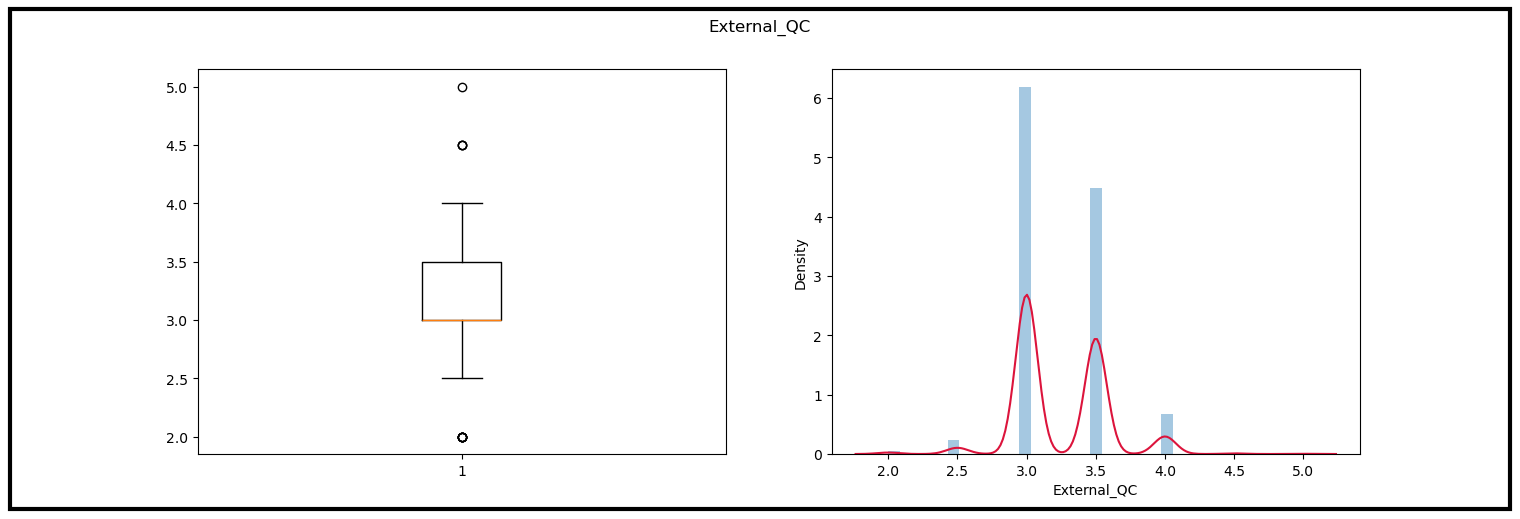

In [288]:
plot_hist_box(df_train.External_QC)

/tmp/ipykernel_4411/3602787827.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  axis[1] = sns.distplot(data)


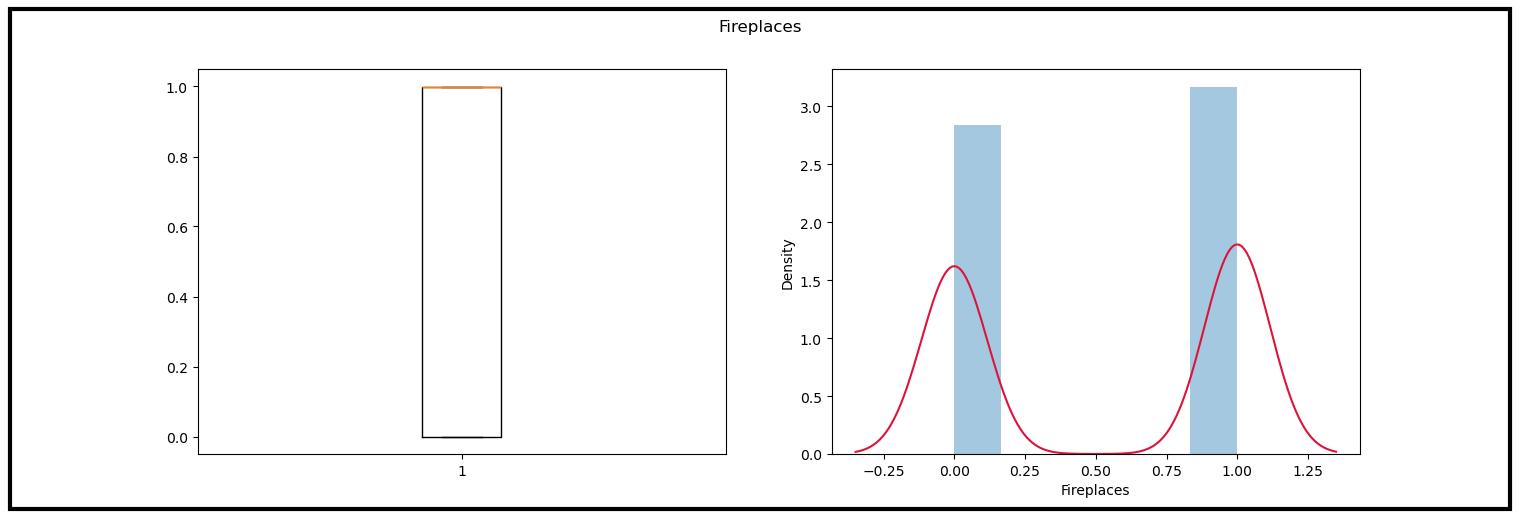

In [289]:
df_train.Fireplaces = (df_train.Fireplaces > 0).astype(int)
plot_hist_box(df_train.Fireplaces)

/tmp/ipykernel_4411/3602787827.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  axis[1] = sns.distplot(data)


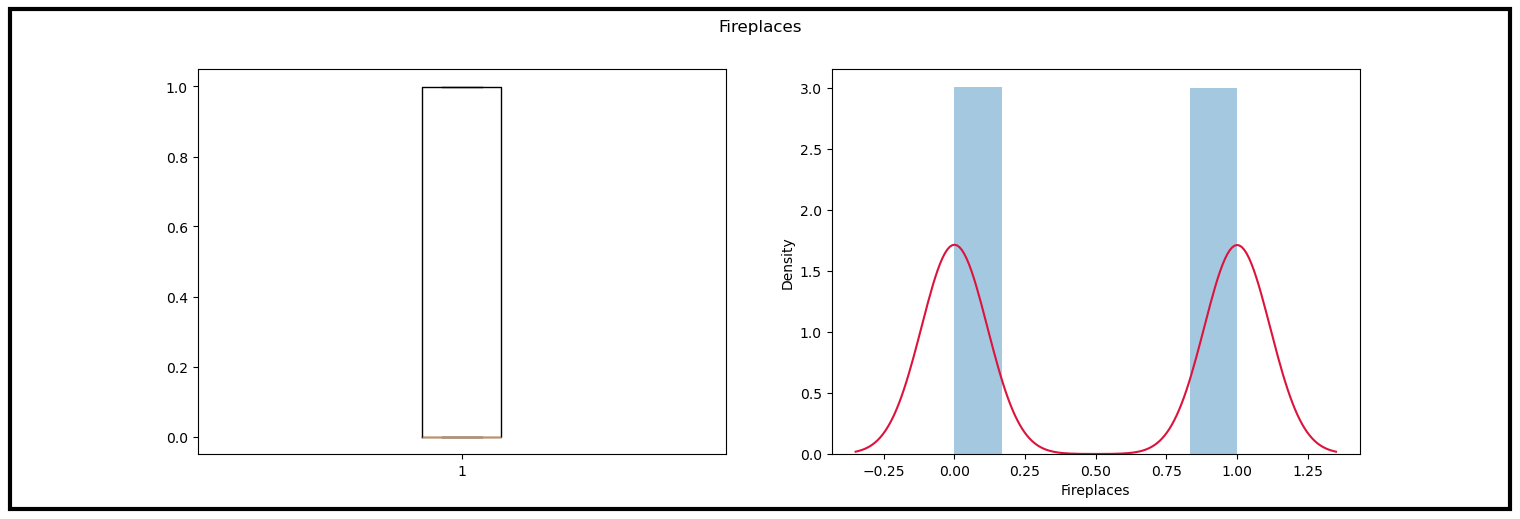

In [290]:
df_test.Fireplaces = (df_test.Fireplaces > 0).astype(int)
plot_hist_box(df_test.Fireplaces)

In [291]:
df_train['Street'].replace(['Pave', 'Grvl'], [0,1], inplace=True)
df_test['Street'].replace(['Pave', 'Grvl'], [0,1], inplace=True)

/tmp/ipykernel_4411/3602787827.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  axis[1] = sns.distplot(data)


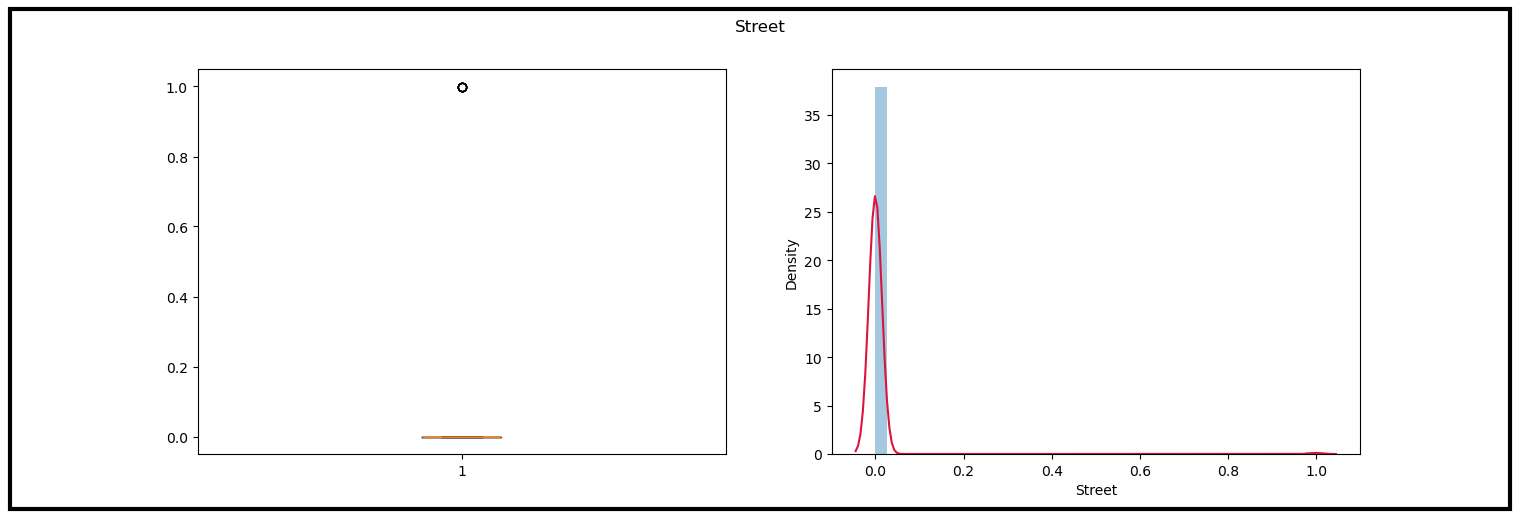

In [292]:
plot_hist_box(df_train.Street)

In [293]:
dum_var = ['LotShape','LandContour','LandSlope','LotConfig','Neighborhood','RoofStyle','PavedDrive','Foundation']

In [294]:
df_train = pd.get_dummies(df_train, columns=dum_var, drop_first=True)
df_test = pd.get_dummies(df_test, columns=dum_var, drop_first=True)

In [295]:
label = {'None':0,'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1}
df_train.HeatingQC.fillna('None',inplace=True)
df_test.HeatingQC.fillna('None',inplace=True)
df_train.replace({'HeatingQC':label},inplace=True)
df_test.replace({'HeatingQC':label},inplace=True)

In [296]:
drop_obj = df_train.columns[df_train.dtypes == '0'].to_list()
df_train.drop(labels=drop_obj, inplace=True, axis=1)
df_test.drop(labels=drop_obj, inplace=True ,axis=1)

In [297]:
df_train.fillna(0, inplace=True)

In [298]:
df_train['Fence'] = train_data.Fence
df_test['Fence'] = test_data.Fence
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

In [299]:
df_train.Fence = (df_train.Fence != 0).astype(int)
df_test.Fence = (df_test.Fence != 0).astype(int)

In [315]:
x = df_train.drop('SalePrice', axis=1)
y = df_train[['SalePrice']]
x = x.apply(pd.to_numeric, errors='coerce')
y = y.apply(pd.to_numeric, errors='coerce')
x.fillna(0, inplace=True)
y.fillna(0, inplace=True)
print(x.shape)
print(y.shape)

(1460, 114)
(1460, 1)


In [316]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print('Training Data: ', x_train.shape[0])
print('Test Data: ', x_test.shape[0])

Training Data:  1168
Test Data:  292


In [317]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [318]:
pred = model.predict(x_test)
pred_train = model.predict(x_train)

In [321]:
print(f"Mean absolute error of test data {mean_absolute_error(y_test, pred)}")
print(f"Mean absolute error of train data {mean_absolute_error(y_train, pred_train)}")
print(f"RMSE of test data {mean_squared_error(y_test, pred, squared=False)}")
print(f"RMSE of train data {mean_squared_error(y_train, pred_train, squared=False)}")
print(f"R^2 of test data {r2_score(y_test, pred)}")
print(f"R^2 of train data {r2_score(y_train, pred_train)}")

Mean absolute error of test data 21640.19300289253
Mean absolute error of train data 19094.83912243615
RMSE of test data 35444.9915773466
RMSE of train data 29831.1122971001
R^2 of test data 0.8362067800009642
R^2 of train data 0.8508026248046483


In [322]:
res_df = pd.DataFrame({'Actual': np.array(y_test).flatten(), 'Predicted': pred.flatten()})
res_df['residual'] = res_df['Actual'] - res_df['Predicted']
res_df.head()

,Actual,Predicted,residual
0,154500,155205.718030,-705.718030
1,325000,323176.422149,1823.577851
2,115000,108653.453558,6346.546442
3,159000,172318.844192,-13318.844192
4,315500,277435.909411,38064.090589


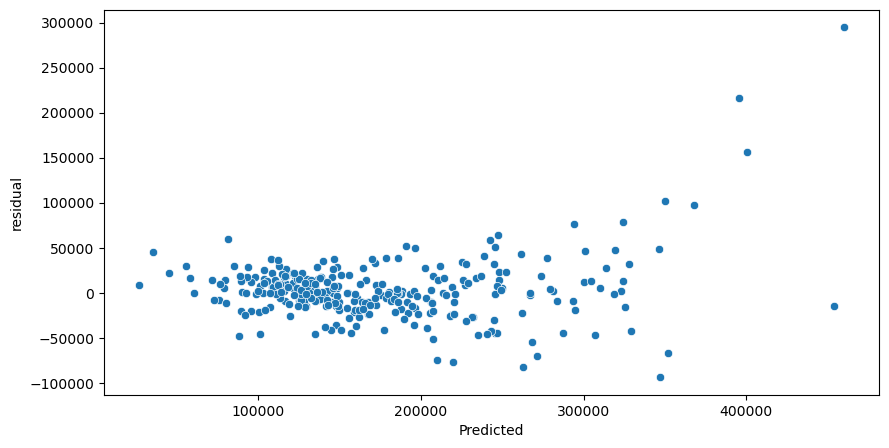

In [324]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=res_df['Predicted'], y=res_df['residual'])
plt.show()

/tmp/ipykernel_4411/4154264072.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(res_df['residual'])


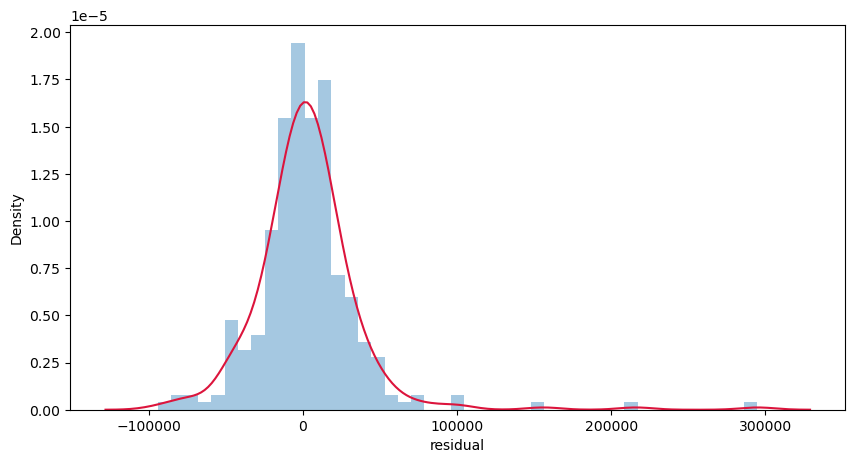

In [325]:
plt.figure(figsize=(10,5))
ax = sns.distplot(res_df['residual'])
ax.lines[0].set_color('crimson')
plt.show()